tensorboard --logidr=./show

In [1]:
number = ['0','1','2','3','4','5','6','7','8','9']
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
ALPHABET = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
CHAR_NUM = len(number) + len(alphabet) + len(ALPHABET)

FLAG_CHAR = 0 # 0:fixed length; 1:variable lenght
CHAR_LEN = 4
MIN_CHAR_LEN = 4
MAX_CHAR_LEN = 6

IMAGE_HEIGHT = 60
IMAGE_WIDTH = 160

CHANNEL = 1

NUM_CNN_LAYERS = 3
CONV_FILTERS = 32
KERNEL_SIZE = 3
POOL_SIZE = 2

DENSE_SIZE = 256
DROPOUT_RATE = 0.5

address_tensorboard = 'show/'
address_model = 'best_model.hdf5'

In [3]:
from captcha.image import ImageCaptcha
from PIL import Image
import random
import string

def get_char_length():
    if FLAG_CHAR == 0:
        char_len = CHAR_LEN
    elif FLAG_CHAR == 1:
        char_len = MAX_CHAR_LEN
    else:
        raise ValueError(u'FLAG_CHAR should be 0 or 1')
        char_len = -1
    return char_len
    
def make_rand_char():
    return random.choice(string.ascii_letters+'0123456789')

def make_rand_text(length):
    text = ''
    for i in range(length):
        rand_char = ''
        r_char = make_rand_char()
        rand_char += r_char
        text += rand_char
    return text

def make_rand_image(text):
    image = ImageCaptcha()
    image = Image.open(image.generate(text))
    return image

def char2pos(c):
    if c >= '0' and c <= '9':
        k = ord(c) - ord('0')
    elif c >= 'a' and c <= 'z':
        k = ord(c) - ord('a') + 10
    elif c >= 'A' and c <= 'Z':
        k = ord(c) - ord('A') + 36
    elif c == '' or c == ' ':
        k = 62
    else:
        print ('character not in lists')
    return k

def pos2char(char_idx):
    if char_idx == -1:
        char = ''
    elif char_idx == 62:
        char = ''
    elif char_idx < 10:
        char = chr(int(char_idx + ord('0')))
    elif char_idx < 36:
        char = chr(int(char_idx - 10 + ord('a')))
    elif char_idx < 62:
        char = chr(int(char_idx - 36 + ord('A')))
    else:
        raise ValueError('error')
    return char

def text2index(text):
    index = []
    for i in text:
        text_index = char2pos(i)
        index.append(text_index)
    return index

def index2text(vec):
    text = ''
    for i in vec:
        char_code = pos2char(i)
        text += char_code
    return "".join(text)

def text2vec(text):
    text_len = len(text)
    length = get_char_length()
    
    if text_len != length:
        raise ValueError(u'Text length does not fit')

    vector = np.zeros(length * CHAR_NUM)
    for i in range(length):
        if i < text_len:
            idx = i * CHAR_NUM + char2pos(text[i])
        else:
            idx = i * CHAR_NUM + char2pos('')
        vector[idx] = 1        
    return vector

def vec2text(vec):
    char_pos = vec.nonzero()[0]
    text = []
    for i, c in enumerate(char_pos):
        char_at_pos = i  # c/63
        char_idx = c % CHAR_NUM
        char_code = pos2char(char_idx)
        text.append(char_code)
    return "".join(text)

def pred2text(pred):
    pred = np.array(pred)
    pred = np.reshape(pred,[-1,CHAR_NUM])
    length = pred.shape[0]
    text = []
    for i in range(length):
        pos = np.argmax(pred[i,:])
        text.append(pos2char(pos))
    return "".join(text)

def rgb2gray(rgb):
    gray = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    #color = 255 - min(t, 10) * 13 if time_color else 255
    return gray

In [4]:
import numpy as np
from keras.applications.mobilenet import preprocess_input

class Generate_Data():
    
    def __init__(self,train_num=512,val_num=128):
        self.train_num = train_num
        self.val_num = val_num
        self.char_len = get_char_length()
            
    def next_train(self):
        while True:
            ret = self.get_next_batch(self.train_num)
            yield ret[1:]
            
    def next_val(self):
        while True:
            ret = self.get_next_batch(self.val_num)
            yield ret[1:]
            
    def test(self):
        ret = self.get_next_batch(128)
        image = ret[0]
        x = ret[1]
        y = ret[2]
        return [image,x,y]
    
    def get_next_batch(self,batch_size=128):
        images = np.zeros([batch_size,IMAGE_HEIGHT,IMAGE_WIDTH,3])
        batch_x = np.zeros([batch_size,IMAGE_HEIGHT,IMAGE_WIDTH,CHANNEL])
        batch_y = np.zeros([batch_size,self.char_len * CHAR_NUM],dtype='int32')
        flag = 0
        while True:
            text = make_rand_text(CHAR_LEN)
            image = make_rand_image(text)
            images[flag,:,:,:] = np.reshape(np.array(image),[IMAGE_HEIGHT,IMAGE_WIDTH,3])
            if CHANNEL == 1:
                image = rgb2gray(np.array(image))  
            batch_x[flag,:,:,:] = np.reshape(image,[IMAGE_HEIGHT,IMAGE_WIDTH,CHANNEL])
            batch_y[flag,:] = text2vec(text)
            flag += 1
            if flag >= batch_size:
                break
        batch_x = preprocess_input(batch_x).astype(np.float32)
        inputs = batch_x
        outputs = batch_y
        return images,inputs,outputs

Using TensorFlow backend.


In [5]:
import keras

class MyCbk(keras.callbacks.Callback):
    # for multi-gpu
    def __init__(self, model,logs={}):
        self.model_to_save = model
        self.min_loss = float('Inf')

    def on_epoch_end(self, epoch, logs={}):
        current_loss = logs.get('val_loss')
        if current_loss < self.min_loss:
            self.model_to_save.save(address_model)
            self.min_loss = current_loss
            print (u'val loss improved, new model saved')
        else:
            print (u'val loss does not improve in this epoch')
        

In [6]:
class Evaluate(keras.callbacks.Callback):
    
    # random show a result in test set
    def __init__(self,val):
        self.x = val[1]
        self.y = val[2]
        self.char_len = get_char_length()
        self.random_index = np.random.randint(self.y.shape[0])
        
    def on_epoch_end(self,epoch,logs={}):
        
        y_pred = self.model.predict(self.x)
        true = vec2text(self.y[self.random_index,:])
        pred = pred2text(y_pred[self.random_index,:])
        print ('True: ',true)
        print ('Pred: ',pred)

In [7]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,TensorBoard
from keras.metrics import categorical_accuracy, categorical_crossentropy
from keras.applications import MobileNet
from keras.utils import multi_gpu_model

import os
import datetime

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "13"

def accuracy(y_true, y_pred):
    char_len = get_char_length()
    y_true = K.reshape(y_true,[-1,char_len,CHAR_NUM])
    y_pred = K.reshape(y_pred,[-1,char_len,CHAR_NUM])

    class_true = K.argmax(y_true,axis=2)
    class_pred = K.argmax(y_pred,axis=2)
    
    correct_pred = K.cast(K.equal(class_true,class_pred),tf.int32)
    correct_pred = K.sum(correct_pred,axis=1) # for each position
    correct_pred = K.cast(K.equal(correct_pred,char_len),tf.int32)
    correct_pred = K.cast(K.sum(correct_pred),tf.float32)
    
    accuracy = correct_pred / K.cast(tf.shape(y_true)[0],tf.float32)
    return accuracy


img_gen = Generate_Data(train_num = 128*4)
length = get_char_length()

input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH,CHANNEL)
model = MobileNet(input_shape=input_shape,alpha=1.,weights=None,classes=CHAR_NUM*length)

#parallel_model = multi_gpu_model(model, 2)
adam = keras.optimizers.Adam(lr = 0.005, beta_1=0.9, beta_2=0.999,decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[accuracy,categorical_accuracy,categorical_crossentropy])
cbk = MyCbk(model)
tensorboard = TensorBoard(log_dir=address_tensorboard,histogram_freq=0)
eva = Evaluate(img_gen.test())
moniter = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, mode='max', cooldown=3, verbose=1)

In [2]:
import numpy as np
import tensorflow as tf

np.random.seed(seed=1992)
tf.set_random_seed(seed=1992)


/home/cancan.zhang/ENV/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/cancan.zhang/ENV/local/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,


In [8]:
hists = []
hist = model.fit_generator(generator=img_gen.next_train(),
                    steps_per_epoch = 600,
                    epochs = 16,
                    validation_data = img_gen.next_val(),
                    validation_steps = 1,
                    verbose = 1,
                    callbacks = [cbk,eva,moniter,tensorboard])
hists.append(hist)

Epoch 1/16
600/600 [==============================] - 2869s 5s/step - loss: 10.1708 - accuracy: 0.4909 - categorical_accuracy: 0.2640 - categorical_crossentropy: 10.1708 - val_loss: 22.1115 - val_accuracy: 0.0312 - val_categorical_accuracy: 0.2188 - val_categorical_crossentropy: 22.1115
val loss improved, new model saved
('True: ', 'aveq')
('Pred: ', 'avee')
Epoch 2/16
600/600 [==============================] - 2740s 5s/step - loss: 6.2705 - accuracy: 0.8793 - categorical_accuracy: 0.2460 - categorical_crossentropy: 6.2705 - val_loss: 8.5010 - val_accuracy: 0.6250 - val_categorical_accuracy: 0.3438 - val_categorical_crossentropy: 8.5010
val loss improved, new model saved
('True: ', 'aveq')
('Pred: ', 'aveq')
Epoch 3/16
600/600 [==============================] - 2674s 4s/step - loss: 6.0391 - accuracy: 0.9120 - categorical_accuracy: 0.2437 - categorical_crossentropy: 6.0391 - val_loss: 5.9565 - val_accuracy: 0.8984 - val_categorical_accuracy: 0.3906 - val_categorical_crossentropy: 5.956

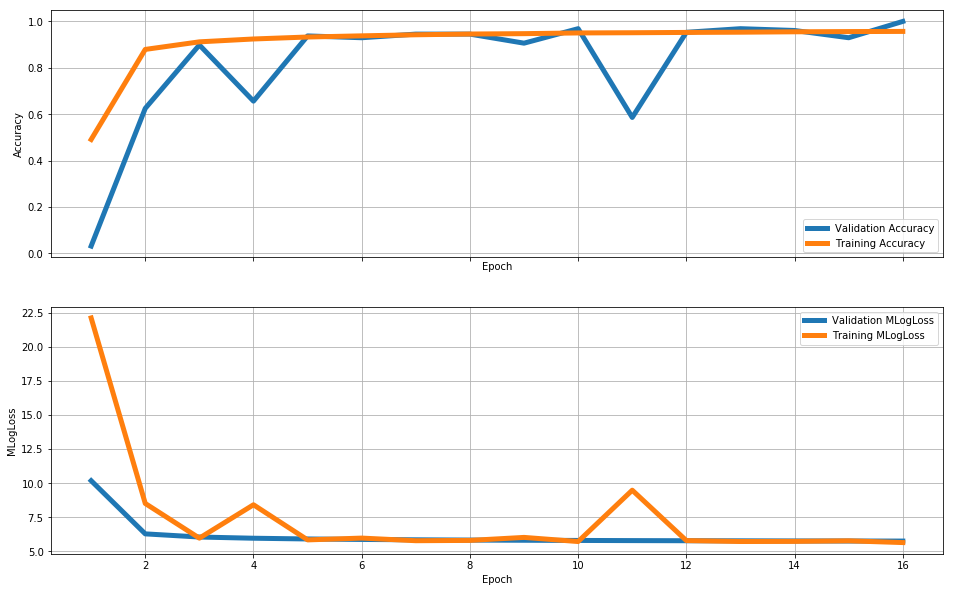

In [11]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt 

hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists])
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();